In [1]:
import pandas as pd
import plotly
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import holidays
import yaml
import optuna
import json
import datetime
import logging
import sys
import os

from datetime import datetime
from prophet import Prophet
from prophet.diagnostics import cross_validation

config_path = r'../config/params.yml'
config = yaml.load(open(config_path), Loader=yaml.FullLoader)

model_path = config['train']['model_path']
params_path = config['train']['params_path']
backend_path = config['train']["backend_path"]
pred_days_forecast = config['train']['pred_days_forecast']
metrics_path = config['train']['metrics_path']
sys.path.append(backend_path)
from get_metrics import get_metrics

In [2]:
# Чтение DataFrame df в файл data/df.csv
df_path = config['preprocessing']['df_path']
df = pd.read_csv(df_path)

# Чтение DataFrame df_train в файл data/df_train.csv
train_path = config['preprocessing']['train_path']
df_train = pd.read_csv(train_path)

# Чтение DataFrame df_test в файл data/df_test.csv
test_path = config['preprocessing']['test_path']
df_test = pd.read_csv(test_path)

In [3]:
# Преобразование столбца ds в формат datetime
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d', dayfirst=True)
df_train['ds'] = pd.to_datetime(df_train['ds'], format='%Y-%m-%d', dayfirst=True)
df_test['ds'] = pd.to_datetime(df_test['ds'], format='%Y-%m-%d', dayfirst=True)

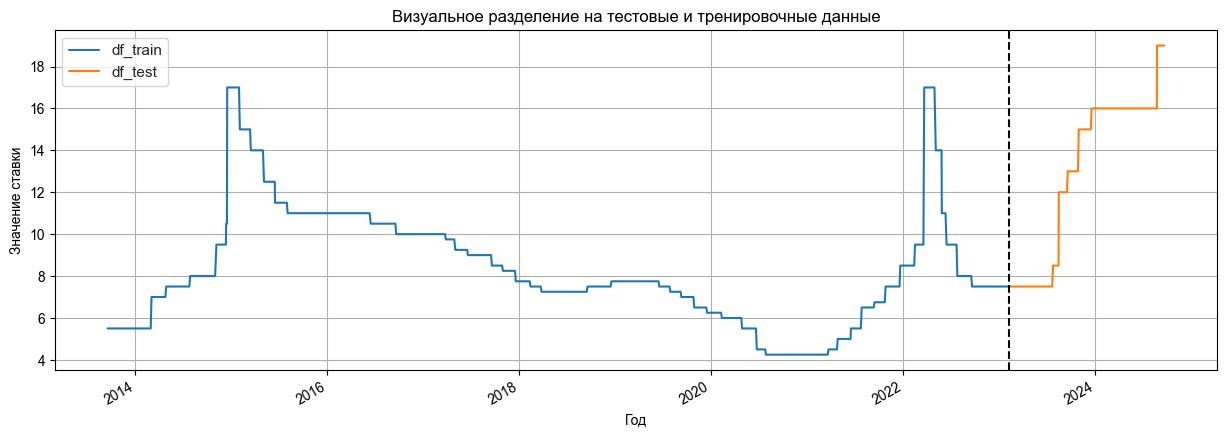

In [4]:
# Отображаем график с разделением train, test для наглядности
fig, ax = plt.subplots(figsize = (10, 5))

sns.set_theme(style="whitegrid", palette="Accent")

fig.set_figheight(5)
fig.set_figwidth(15)
df_train.set_index('ds').plot(ax=ax, label= 'train', title='Визуальное разделение на тестовые и тренировочные данные')
df_test.set_index('ds').plot(ax=ax, label='test')
ax.axvline(df_train['ds'][-1:].values, ls='--', color='black')
ax.legend(['df_train', 'df_test'])
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

In [5]:
# Период, который надо отрезать и предсказать (проверка модели)
pred_days = int(df.shape[0]*config['parcing']['pred_days'])

# Baseline Prophet on df_train для проверки модели

In [6]:
def train_model(df, **kwargs):
    """
    Обучение модели Prophet на данных.

    Аргументы:
        pandas.DataFrame: Данные для обучения с datetime и курсами.
        **kwargs: Параметры для модели Prophet.
    Возвращает: 
        Обученная модель.
    """
    model = Prophet(**kwargs)
    model.fit(df)
    return model

In [7]:
# Обучение модели на train
model_baseline = train_model(df_train)

00:35:28 - cmdstanpy - INFO - Chain [1] start processing
00:35:29 - cmdstanpy - INFO - Chain [1] done processing


In [8]:
def generate_forecast(model, pred_days):
    """
    Генерирует прогноз на заданное количество дней вперед.

    Параметры:
    - model: модель, используемая для прогнозирования
    - pred_days: количество дней, на которое нужно сделать прогноз

    Возвращает:
    - forecast: DataFrame с прогнозом
    """
    future = model.make_future_dataframe(periods=pred_days, freq='D')
    forecast = model.predict(future)
    return forecast

In [9]:
# Создание df с прогнозом
forecast = generate_forecast(model_baseline, pred_days)

In [10]:
def plot_forecast(model, forecast):
    """
    Отображает график прогноза и компоненты модели.

    Параметры:
    model (модель): Модель, использованная для прогнозирования.
    forecast (прогноз): Прогноз, полученный с помощью модели.

    Возвращает:
    None
    """

    FIGSIZE = (15, 5)
    # Смотрим график прогноза
    fig, ax = plt.subplots(1, figsize=FIGSIZE)
    model.plot(forecast, ax=ax)
    plt.show()

    # Смотрим тренд, годовые и сезонные признаки
    fig, ax = plt.subplots(1, figsize=FIGSIZE)
    model.plot_components(forecast)
    plt.show()

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


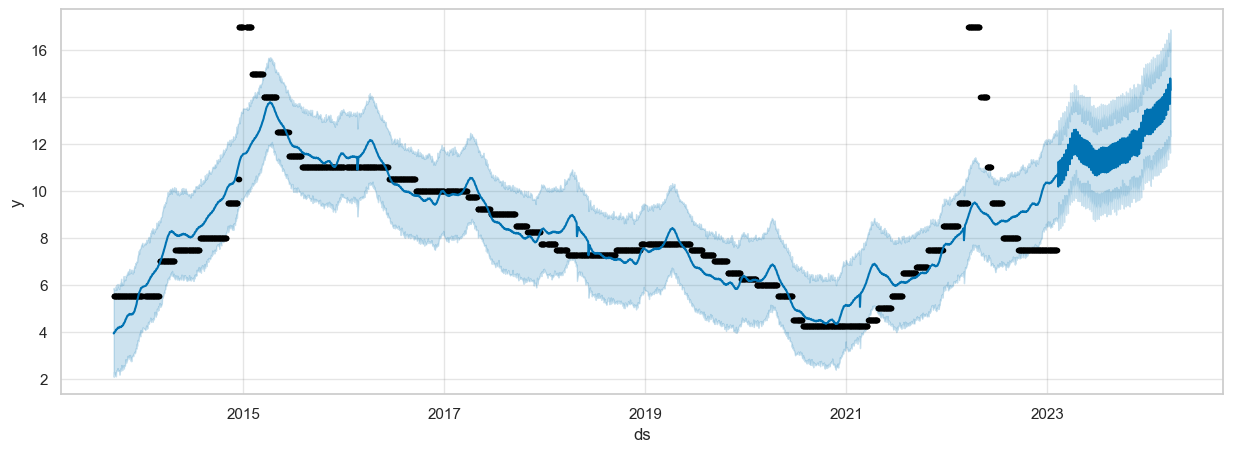

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series cont

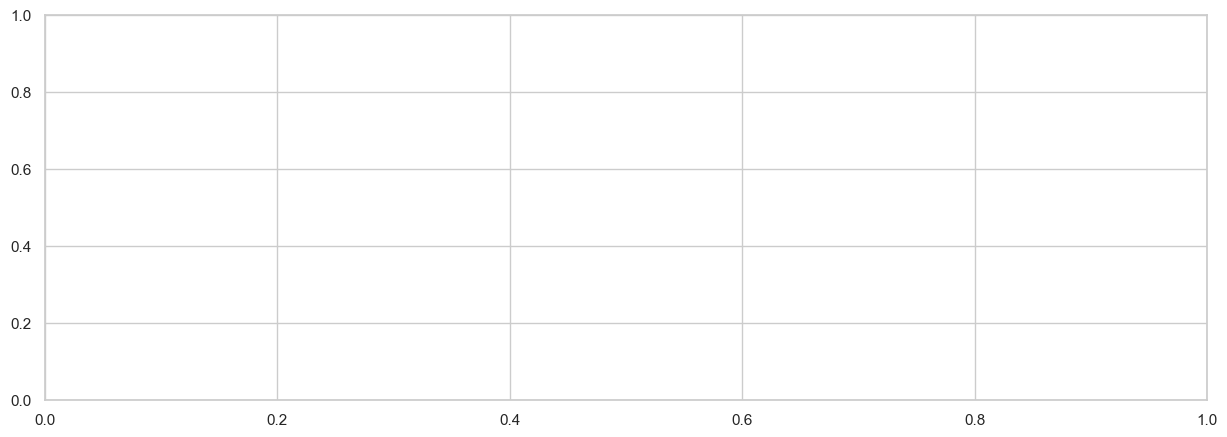

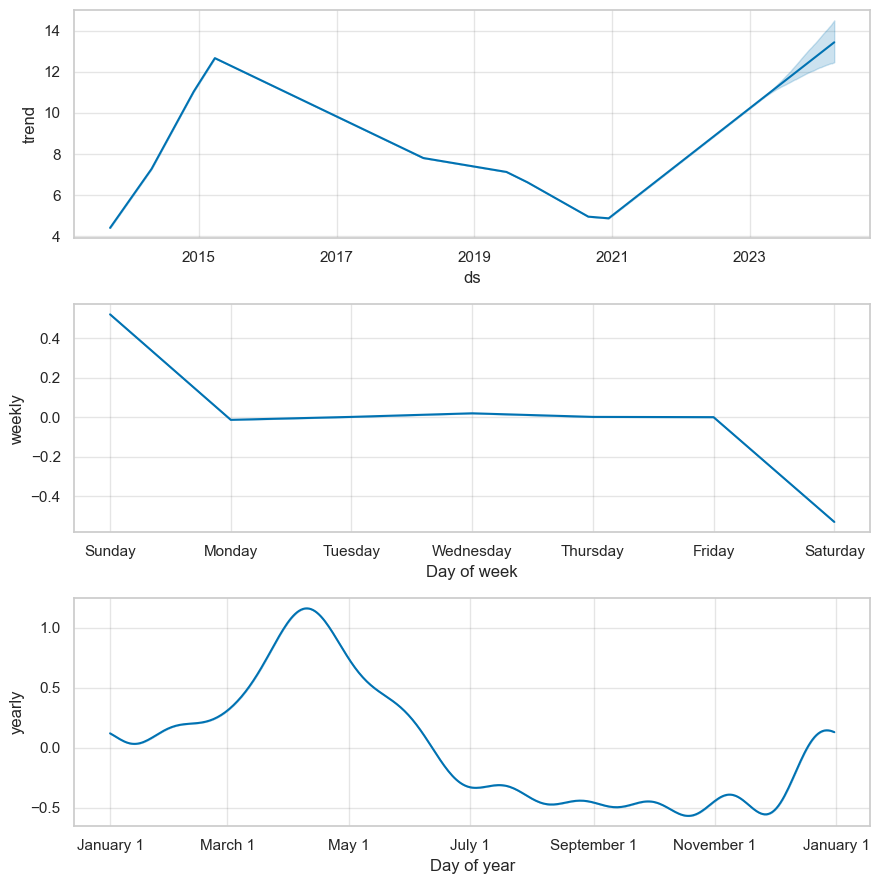

In [11]:
# Смотрим график прогноза, тренд, годовые и сезонные признаки
plot_forecast(model_baseline, forecast)

## Сравнение фактов и прогнозов

In [12]:
# Создание df с прогнозом
df_test_forecast = model_baseline.predict(df_test)
df_test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
408,2024-09-16,14.179333,11.434854,17.072643
409,2024-09-17,14.204754,11.218251,16.912728
410,2024-09-18,14.233923,11.504086,17.047770
411,2024-09-19,14.227218,11.584706,17.044105
412,2024-09-20,14.237631,11.487203,17.011989


c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


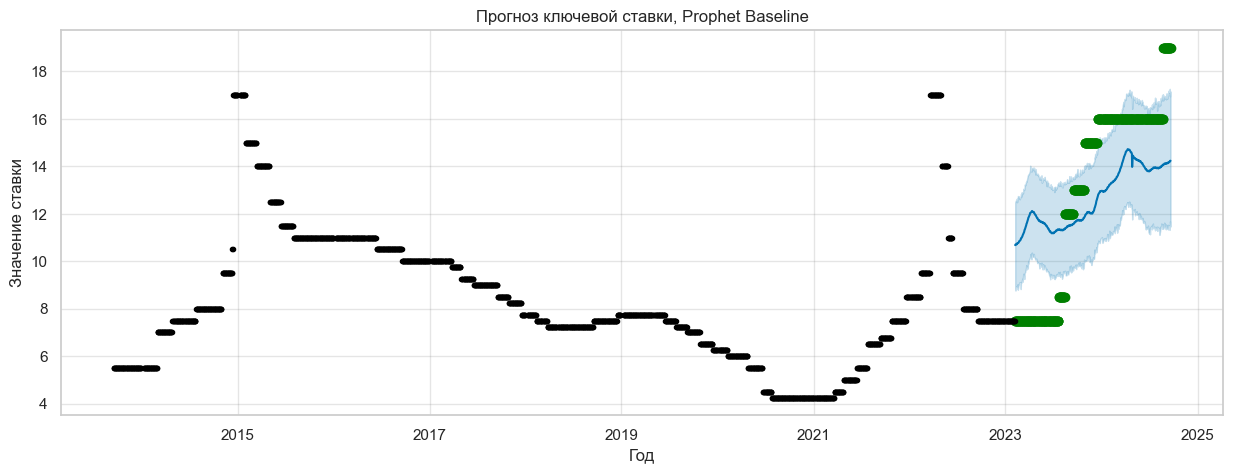

In [13]:
# Смотрим совпадение фактического курса с предсказанным курсом prophet baseline обученным на train
fig, ax = plt.subplots(figsize= (10, 5))

fig.set_figheight(5)
fig.set_figwidth(15)
predict = model_baseline.predict(df_test)
fig = model_baseline.plot(predict, ax=ax)
ax.scatter(df_test.ds, df_test['y'], color = 'g')
ax.set_title('Прогноз ключевой ставки, Prophet Baseline')
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

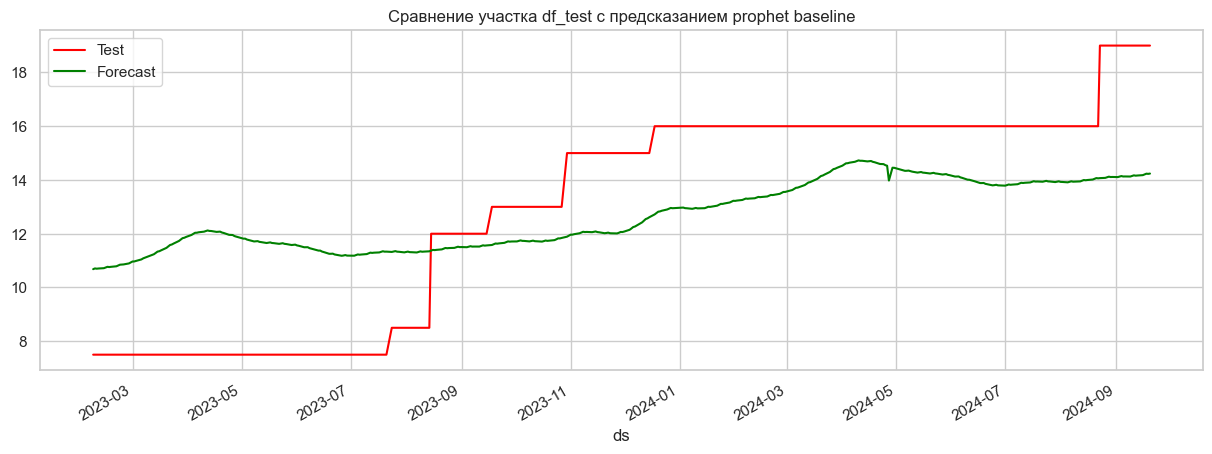

In [14]:
# Сравнение участка df_test с предсказанием prophet baseline
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet baseline')
plt.show()

In [15]:
# Просмотр метрик модели обученной на train
metrics = get_metrics(y_test=df_test['y'], y_pred=df_test_forecast['yhat'], name='Prophet_baseline')
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,2.719605,0.253811,8.776287,2.96248


Из приведенного выше графика мы видим, что существует разрыв в прогнозах и фактических данных. Поэтому нам нужно оптимизировать модель, добавив другие параметры, напрмиер, такие как праздники

# Prophet with holidays

In [16]:
# Создаем df праздников в РФ начиная с 2013 по сегодня
holiday = pd.DataFrame([])
for date, name in sorted(holidays.Russia(years=[2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024]).items()):
    new_row = pd.DataFrame({'ds': date, 'holiday': "RU-Holidays"}, index=[0])
    holiday = pd.concat([holiday, new_row], ignore_index=True)  

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

C:\Users\myxa-\AppData\Local\Temp\ipykernel_18780\3236026523.py:7: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')


In [17]:
# Тренировка модели с праздниками
model_with_holidays = train_model(df_train, holidays=holiday)

00:35:33 - cmdstanpy - INFO - Chain [1] start processing
00:35:33 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Создание df с прогнозом
forecast = generate_forecast(model_with_holidays, pred_days)

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


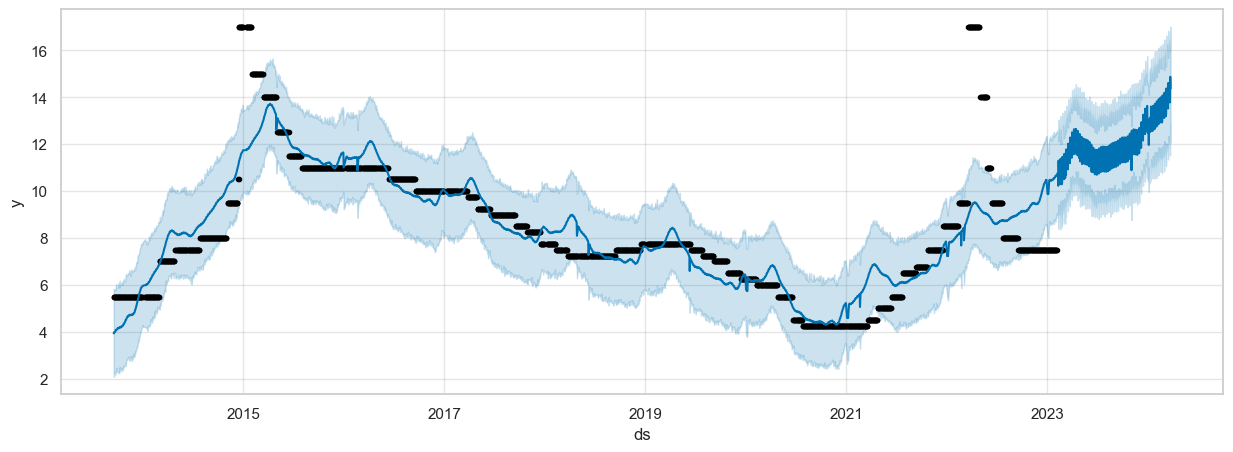

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series cont

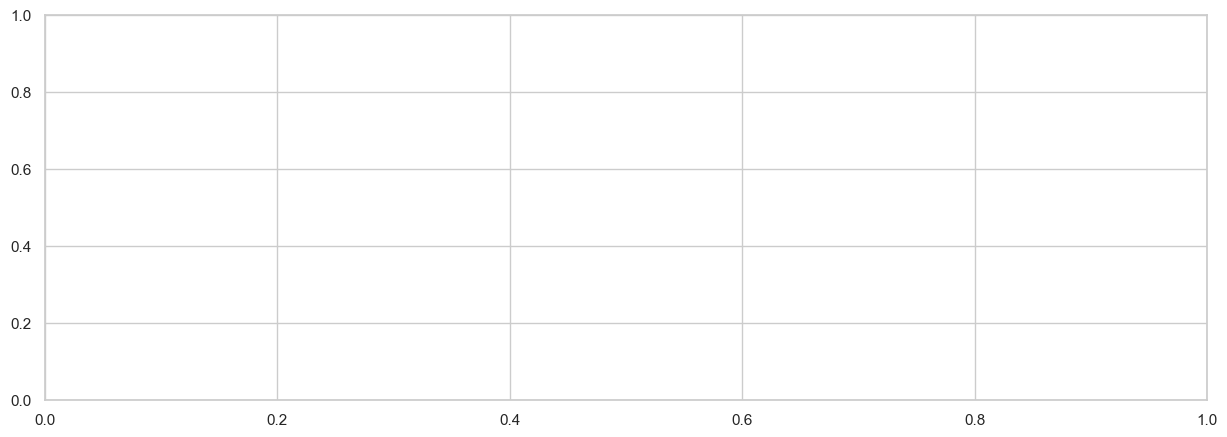

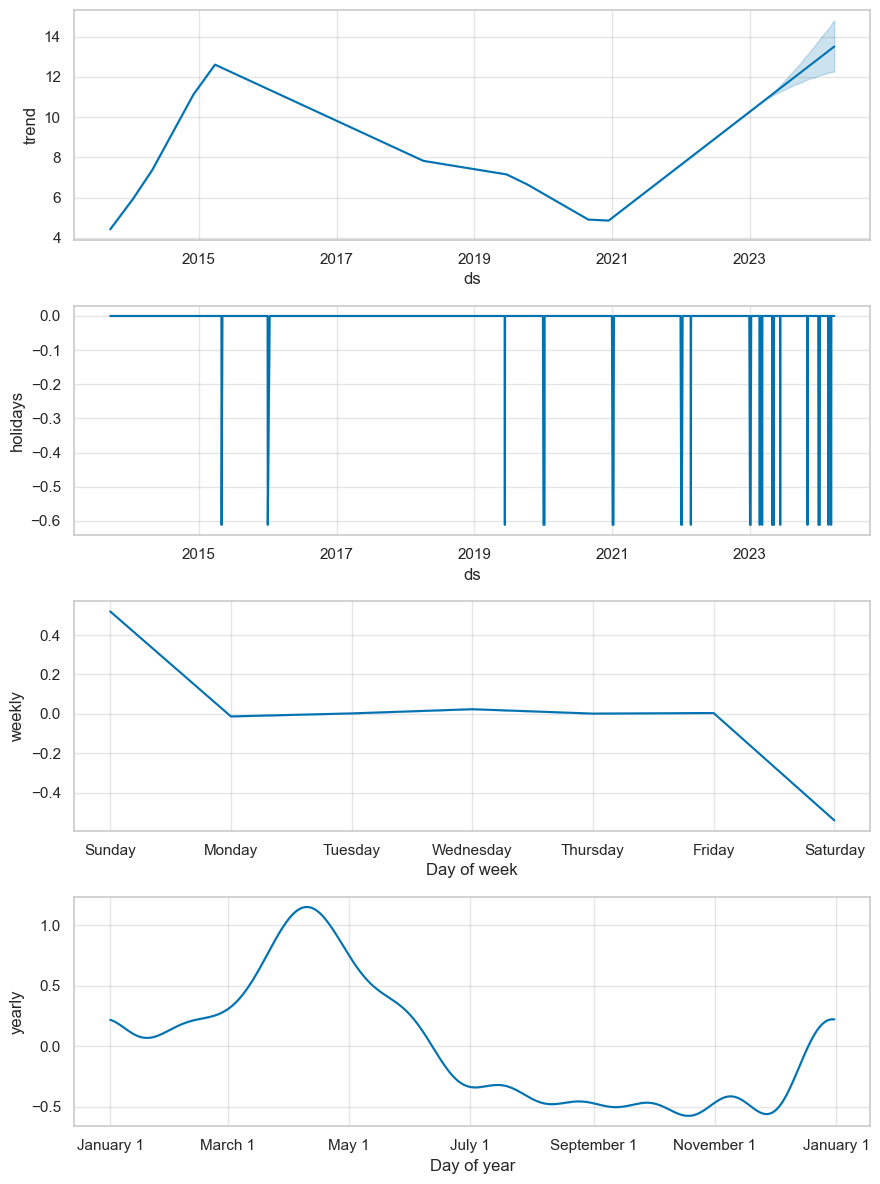

In [19]:
# Смотрим график прогноза, тренд, годовые и сезонные признаки обученной модели с праздниками
plot_forecast(model_with_holidays, forecast)

## Сравнение фактов и прогнозов

In [20]:
# Создание df с прогнозом
df_test_forecast_holiday = model_with_holidays.predict(df_test)
df_test_forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
408,2024-09-16,14.258008,11.526010,16.991924
409,2024-09-17,14.283294,11.420751,17.077739
410,2024-09-18,14.314983,11.476753,17.206554
411,2024-09-19,14.303440,11.494912,17.167584
412,2024-09-20,14.317149,11.446668,17.095527


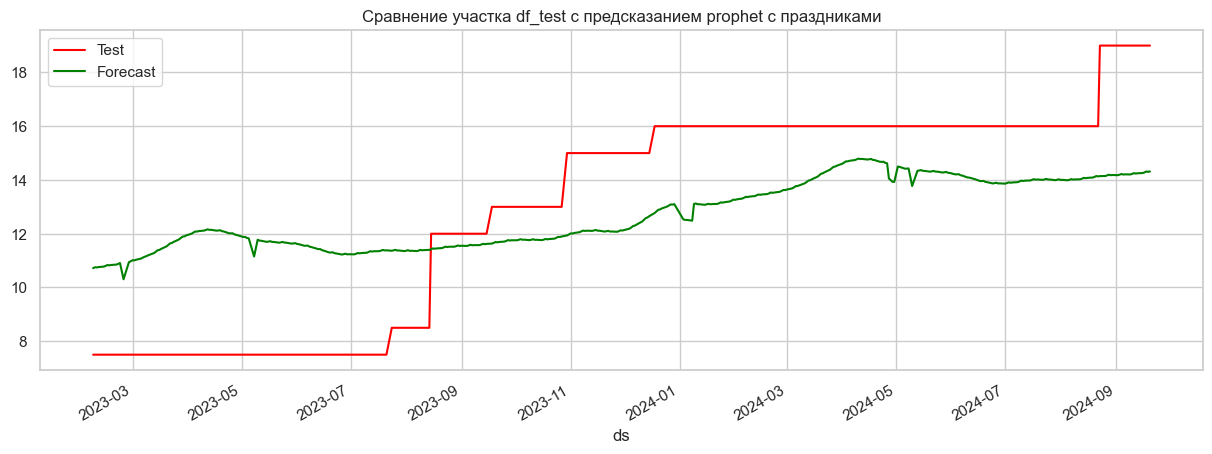

In [21]:
# Сравнение участка df_test с предсказанием prophet_with_holidays
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_holiday.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet с праздниками')
plt.show()

In [22]:
# Сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_holiday['yhat'], name='Prophet_with_holidays')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,2.719605,0.253811,8.776287,2.962480
0,Prophet_with_holidays,2.694707,0.253057,8.712505,2.951695


Из метрик и графиков видим, что модель с праздниками показывает результаты немного изменились.

# Тюнинг тест модели

In [23]:
def optimize_prophet_hyperparameters(df_train, model_path, params_path, config):
    """
    Функция оптимизации гиперпараметров модели Prophet.

    Параметры:
    - df_train (pd.DataFrame): Данные для обучения модели.
    - model_path (str): Путь к директории, где будет сохранена лучшая модель.
    - params_path (str): Путь к директории, где будут сохранены лучшие параметры.
    - config (dict): Словарь с конфигурацией.

    Возвращает:
    - prophet_best_params (dict): Лучшие параметры модели Prophet.
    """

    # Определите целевую функцию для оптимизации
    def objective(trial):
        best_score = float('inf')
        # Гиперпараметры для настройки
        changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', 0.001, 0.5)
        seasonality_prior_scale = trial.suggest_float('seasonality_prior_scale', 0.01, 10)
        holidays_prior_scale = trial.suggest_float('holidays_prior_scale', 0.01, 10)
        seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])

        # Создайте модель Prophet с гиперпараметрами
        model = Prophet(changepoint_prior_scale=changepoint_prior_scale,
                        seasonality_prior_scale=seasonality_prior_scale,
                        holidays_prior_scale=holidays_prior_scale,
                        seasonality_mode=seasonality_mode,
                        )

        # Обучите модель
        model.fit(df_train)

        # Выполните кросс-валидацию
        cv_results = cross_validation(model, initial='730 days', period='180 days', horizon='30 days')

        # Расчет MAE
        mae = np.mean(np.abs(cv_results['y'] - cv_results['yhat']))

        score = mae

        # Обновляем best_score только если MAE лучше
        if score < best_score:
            best_score = score

        return score

    # Проверьте, существует ли сохраненная модель и лучшие параметры
    best_model_file = os.path.join(model_path, 'prophet_best_model.json')
    best_params_file = os.path.join(params_path, 'prophet_best_params.json')
    prophet_best_params = None
    if os.path.exists(best_model_file) and os.path.exists(best_params_file):
        print('Модель и параметры уже сохранены.')
        with open(best_model_file, 'r') as f:
            prophet_best_model = json.load(f)
        with open(best_params_file, 'r') as f:
            prophet_best_params = json.load(f)
        print('Лучшие параметры:', prophet_best_params)
    else:
        print('Модель или параметры не сохранены, выполняем поиск гиперпараметров')
        # Выполните поиск гиперпараметров с помощью Optuna
        study = optuna.create_study(direction='minimize')
        best_score = float('-inf')
        logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
        study.optimize(objective, n_trials=config['train']['N_TRIALS'], timeout=config['train']['TIMEOUT'])
        prophet_best_params = study.best_params
        # Сохраните модель и лучшие параметры
        with open(best_model_file, 'w') as f:
            json.dump(prophet_best_params, f, indent=4)
        with open(best_params_file, 'w') as f:
            json.dump(study.best_params, f, indent=4)
        print('Модель и параметры сохранены')
        print('Лучшие параметры:', study.best_params)

    return prophet_best_params

In [24]:
# Обучение модели на лучших параметрах
prophet_best_params = optimize_prophet_hyperparameters(df_train, model_path, params_path, config)

[I 2024-09-22 00:35:36,776] A new study created in memory with name: no-name-e91bd919-eef8-4039-a310-f151e6e6af83


Модель или параметры не сохранены, выполняем поиск гиперпараметров


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:35:59,796] Trial 0 finished with value: 1.107716076694544 and parameters: {'changepoint_prior_scale': 0.3945265474490321, 'seasonality_prior_scale': 6.736548942854692, 'holidays_prior_scale': 5.2482779841329945, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 1.107716076694544.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:36:42,255] Trial 1 finished with value: 1.4086372440318435 and parameters: {'changepoint_prior_scale': 0.17933549485722503, 'seasonality_prior_scale': 4.943083728634096, 'holidays_prior_scale': 5.968017865515915, 'seasonality_mode': 'multiplicative'}. Best is trial 0 with value: 1.107716076694544.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:37:04,997] Trial 2 finished with value: 1.1113651613464355 and parameters: {'changepoint_prior_scale': 0.489419321481805, 'seasonality_prior_scale': 1.6583134240934152, 'holidays_prior_scale': 7.53088085383145, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 1.107716076694544.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:37:27,280] Trial 3 finished with value: 1.11130291874736 and parameters: {'changepoint_prior_scale': 0.4589382745883999, 'seasonality_prior_scale': 6.706845045913568, 'holidays_prior_scale': 3.880546942200833, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 1.107716076694544.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:37:49,037] Trial 4 finished with value: 1.1036942712169067 and parameters: {'changepoint_prior_scale': 0.2549222625549016, 'seasonality_prior_scale': 1.7826665556295571, 'holidays_prior_scale': 4.7743757249387215, 'seasonality_mode': 'additive'}. Best is trial 4 with value: 1.1036942712169067.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:38:02,629] Trial 5 finished with value: 1.1213935343449526 and parameters: {'changepoint_prior_scale': 0.032496014272506306, 'seasonality_prior_scale': 0.3792828376362734, 'holidays_prior_scale': 4.735380752824775, 'seasonality_mode': 'additive'}. Best is trial 4 with value: 1.1036942712169067.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:38:40,442] Trial 6 finished with value: 1.46379828996981 and parameters: {'changepoint_prior_scale': 0.2566077695774173, 'seasonality_prior_scale': 9.350040637786467, 'holidays_prior_scale': 4.7472254189022705, 'seasonality_mode': 'multiplicative'}. Best is trial 4 with value: 1.1036942712169067.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:38:59,132] Trial 7 finished with value: 1.088258030786917 and parameters: {'changepoint_prior_scale': 0.11483795633467131, 'seasonality_prior_scale': 2.421839615943014, 'holidays_prior_scale': 6.63802160133577, 'seasonality_mode': 'additive'}. Best is trial 7 with value: 1.088258030786917.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:39:31,565] Trial 8 finished with value: 1.4947893781476898 and parameters: {'changepoint_prior_scale': 0.4820340355529381, 'seasonality_prior_scale': 4.1022984354899945, 'holidays_prior_scale': 8.001596219084202, 'seasonality_mode': 'multiplicative'}. Best is trial 7 with value: 1.088258030786917.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:40:11,315] Trial 9 finished with value: 1.49296138285632 and parameters: {'changepoint_prior_scale': 0.4493534144904606, 'seasonality_prior_scale': 5.760072080582054, 'holidays_prior_scale': 4.862793036935571, 'seasonality_mode': 'multiplicative'}. Best is trial 7 with value: 1.088258030786917.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:40:20,177] Trial 10 finished with value: 1.2364684769022307 and parameters: {'changepoint_prior_scale': 0.011250953436253902, 'seasonality_prior_scale': 3.378553015584973, 'holidays_prior_scale': 1.0469097019002884, 'seasonality_mode': 'additive'}. Best is trial 7 with value: 1.088258030786917.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:40:40,475] Trial 11 finished with value: 1.1050472404171303 and parameters: {'changepoint_prior_scale': 0.18587022231362907, 'seasonality_prior_scale': 2.233818107362591, 'holidays_prior_scale': 9.42508204056653, 'seasonality_mode': 'additive'}. Best is trial 7 with value: 1.088258030786917.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:41:03,596] Trial 12 finished with value: 1.1042847409241374 and parameters: {'changepoint_prior_scale': 0.2935898171657455, 'seasonality_prior_scale': 0.06894054889881307, 'holidays_prior_scale': 2.3730630770069663, 'seasonality_mode': 'additive'}. Best is trial 7 with value: 1.088258030786917.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:41:22,116] Trial 13 finished with value: 1.076244703536225 and parameters: {'changepoint_prior_scale': 0.10390451662183176, 'seasonality_prior_scale': 2.1359282263560724, 'holidays_prior_scale': 7.588673730998737, 'seasonality_mode': 'additive'}. Best is trial 13 with value: 1.076244703536225.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:41:39,871] Trial 14 finished with value: 1.0733495294176638 and parameters: {'changepoint_prior_scale': 0.09819120911503809, 'seasonality_prior_scale': 3.0437686472161936, 'holidays_prior_scale': 7.2073605529321325, 'seasonality_mode': 'additive'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:41:56,937] Trial 15 finished with value: 1.0842098825093038 and parameters: {'changepoint_prior_scale': 0.09200376057841828, 'seasonality_prior_scale': 3.4768015938297463, 'holidays_prior_scale': 9.545486131914672, 'seasonality_mode': 'additive'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:42:14,997] Trial 16 finished with value: 1.077806297162759 and parameters: {'changepoint_prior_scale': 0.09843247710706465, 'seasonality_prior_scale': 8.969764019687485, 'holidays_prior_scale': 7.75762713580073, 'seasonality_mode': 'additive'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:42:33,838] Trial 17 finished with value: 1.0938188348886038 and parameters: {'changepoint_prior_scale': 0.16403567028481086, 'seasonality_prior_scale': 1.076039908640708, 'holidays_prior_scale': 8.59976726987089, 'seasonality_mode': 'additive'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:43:08,768] Trial 18 finished with value: 1.4610683351588711 and parameters: {'changepoint_prior_scale': 0.32199906843363163, 'seasonality_prior_scale': 2.9126430711092746, 'holidays_prior_scale': 6.905002066812406, 'seasonality_mode': 'multiplicative'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:43:23,706] Trial 19 finished with value: 1.0768677773232682 and parameters: {'changepoint_prior_scale': 0.044702502062019894, 'seasonality_prior_scale': 4.5123747604438975, 'holidays_prior_scale': 8.670604954274523, 'seasonality_mode': 'additive'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:43:42,505] Trial 20 finished with value: 1.0862753994078163 and parameters: {'changepoint_prior_scale': 0.13995209889542598, 'seasonality_prior_scale': 5.793956937508496, 'holidays_prior_scale': 3.56860259099256, 'seasonality_mode': 'additive'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:43:57,249] Trial 21 finished with value: 1.0874565328415509 and parameters: {'changepoint_prior_scale': 0.04556853790265149, 'seasonality_prior_scale': 4.291847290481631, 'holidays_prior_scale': 8.949195902969196, 'seasonality_mode': 'additive'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:44:11,738] Trial 22 finished with value: 1.102150039260195 and parameters: {'changepoint_prior_scale': 0.06303187106141309, 'seasonality_prior_scale': 4.9019041991693095, 'holidays_prior_scale': 6.622416312567983, 'seasonality_mode': 'additive'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:44:19,691] Trial 23 finished with value: 1.776257987823128 and parameters: {'changepoint_prior_scale': 0.0027603059902093496, 'seasonality_prior_scale': 3.7929087622121744, 'holidays_prior_scale': 8.461302137290023, 'seasonality_mode': 'additive'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:44:35,303] Trial 24 finished with value: 1.1016455221197812 and parameters: {'changepoint_prior_scale': 0.07283546232043925, 'seasonality_prior_scale': 1.0742046823334568, 'holidays_prior_scale': 7.316122085297646, 'seasonality_mode': 'additive'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:44:56,186] Trial 25 finished with value: 1.103656225761645 and parameters: {'changepoint_prior_scale': 0.216057454516642, 'seasonality_prior_scale': 2.881337651864862, 'holidays_prior_scale': 6.050620218981168, 'seasonality_mode': 'additive'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:45:38,950] Trial 26 finished with value: 1.3948587734188045 and parameters: {'changepoint_prior_scale': 0.13037592711006563, 'seasonality_prior_scale': 7.592411620374535, 'holidays_prior_scale': 9.848394772202441, 'seasonality_mode': 'multiplicative'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:46:00,495] Trial 27 finished with value: 1.1100814606121185 and parameters: {'changepoint_prior_scale': 0.20958554438445234, 'seasonality_prior_scale': 4.559111479532296, 'holidays_prior_scale': 8.199784287779474, 'seasonality_mode': 'additive'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:46:18,561] Trial 28 finished with value: 1.0872407987610013 and parameters: {'changepoint_prior_scale': 0.14481428189201156, 'seasonality_prior_scale': 5.647427319347351, 'holidays_prior_scale': 5.81494889484061, 'seasonality_mode': 'additive'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:46:41,392] Trial 29 finished with value: 1.111730721633486 and parameters: {'changepoint_prior_scale': 0.3459802578691193, 'seasonality_prior_scale': 6.949700136812403, 'holidays_prior_scale': 8.98507240282312, 'seasonality_mode': 'additive'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:46:56,914] Trial 30 finished with value: 1.1086664865986873 and parameters: {'changepoint_prior_scale': 0.06985687500573762, 'seasonality_prior_scale': 2.927044031566599, 'holidays_prior_scale': 7.052018298126107, 'seasonality_mode': 'additive'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:47:15,363] Trial 31 finished with value: 1.0830354650813179 and parameters: {'changepoint_prior_scale': 0.10649736842518505, 'seasonality_prior_scale': 8.978073933644149, 'holidays_prior_scale': 7.758711460950905, 'seasonality_mode': 'additive'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:47:33,091] Trial 32 finished with value: 1.0822083742548512 and parameters: {'changepoint_prior_scale': 0.0931594703729553, 'seasonality_prior_scale': 7.9680156813242835, 'holidays_prior_scale': 7.911871853671738, 'seasonality_mode': 'additive'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:47:47,146] Trial 33 finished with value: 1.0974228964739943 and parameters: {'changepoint_prior_scale': 0.03667214808972259, 'seasonality_prior_scale': 5.183858563941067, 'holidays_prior_scale': 6.293488968077621, 'seasonality_mode': 'additive'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:48:08,378] Trial 34 finished with value: 1.1062015404473216 and parameters: {'changepoint_prior_scale': 0.17397604797091454, 'seasonality_prior_scale': 8.562662068643792, 'holidays_prior_scale': 7.510655363292887, 'seasonality_mode': 'additive'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:48:23,951] Trial 35 finished with value: 1.1063698327657314 and parameters: {'changepoint_prior_scale': 0.06817084378942301, 'seasonality_prior_scale': 6.489707572642501, 'holidays_prior_scale': 5.62694403001812, 'seasonality_mode': 'additive'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:48:56,276] Trial 36 finished with value: 1.2874422791366897 and parameters: {'changepoint_prior_scale': 0.02628056849215442, 'seasonality_prior_scale': 9.966997015484967, 'holidays_prior_scale': 8.890329996388624, 'seasonality_mode': 'multiplicative'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:49:14,707] Trial 37 finished with value: 1.0878413017325474 and parameters: {'changepoint_prior_scale': 0.12294197944746688, 'seasonality_prior_scale': 1.2858884606696896, 'holidays_prior_scale': 9.994262222143005, 'seasonality_mode': 'additive'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:49:36,252] Trial 38 finished with value: 1.105068783210939 and parameters: {'changepoint_prior_scale': 0.22428460528992672, 'seasonality_prior_scale': 2.0300878422185438, 'holidays_prior_scale': 5.3668826964845895, 'seasonality_mode': 'additive'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:49:55,894] Trial 39 finished with value: 1.0950731841071737 and parameters: {'changepoint_prior_scale': 0.16049713691194514, 'seasonality_prior_scale': 3.5495073458654063, 'holidays_prior_scale': 3.9348449256721802, 'seasonality_mode': 'additive'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:50:37,747] Trial 40 finished with value: 1.3670425773980226 and parameters: {'changepoint_prior_scale': 0.09519957437324053, 'seasonality_prior_scale': 2.549789794846855, 'holidays_prior_scale': 7.508934117567899, 'seasonality_mode': 'multiplicative'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:50:56,107] Trial 41 finished with value: 1.076234403244337 and parameters: {'changepoint_prior_scale': 0.1038652410011047, 'seasonality_prior_scale': 7.899955209278813, 'holidays_prior_scale': 8.108038485607034, 'seasonality_mode': 'additive'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:51:10,349] Trial 42 finished with value: 1.0789817360018954 and parameters: {'changepoint_prior_scale': 0.04649657262367514, 'seasonality_prior_scale': 7.995766218355677, 'holidays_prior_scale': 8.298988632903601, 'seasonality_mode': 'additive'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:51:28,193] Trial 43 finished with value: 1.0772174036030162 and parameters: {'changepoint_prior_scale': 0.11240496277198815, 'seasonality_prior_scale': 8.985219464179846, 'holidays_prior_scale': 9.227624268601875, 'seasonality_mode': 'additive'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:51:47,803] Trial 44 finished with value: 1.0909853849232953 and parameters: {'changepoint_prior_scale': 0.1468746539933859, 'seasonality_prior_scale': 9.944818218831228, 'holidays_prior_scale': 9.07353439680421, 'seasonality_mode': 'additive'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:52:07,996] Trial 45 finished with value: 1.0809712704109182 and parameters: {'changepoint_prior_scale': 0.11576729118233903, 'seasonality_prior_scale': 6.3107539449433565, 'holidays_prior_scale': 9.359098832419214, 'seasonality_mode': 'additive'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:52:29,628] Trial 46 finished with value: 1.10119543549847 and parameters: {'changepoint_prior_scale': 0.18779741453980228, 'seasonality_prior_scale': 1.7729515166632668, 'holidays_prior_scale': 8.28434194540205, 'seasonality_mode': 'additive'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:52:38,867] Trial 47 finished with value: 1.2073800346875567 and parameters: {'changepoint_prior_scale': 0.01654646472973867, 'seasonality_prior_scale': 7.063084574180859, 'holidays_prior_scale': 6.542657225293174, 'seasonality_mode': 'additive'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:52:59,480] Trial 48 finished with value: 1.2835591198281882 and parameters: {'changepoint_prior_scale': 0.05602756570320773, 'seasonality_prior_scale': 0.6733319512030151, 'holidays_prior_scale': 0.5830076657520964, 'seasonality_mode': 'multiplicative'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:53:21,578] Trial 49 finished with value: 1.1073283664494753 and parameters: {'changepoint_prior_scale': 0.4214979398406711, 'seasonality_prior_scale': 9.535674372892753, 'holidays_prior_scale': 8.577867982062957, 'seasonality_mode': 'additive'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:53:43,541] Trial 50 finished with value: 1.1091400667516111 and parameters: {'changepoint_prior_scale': 0.2796959662474858, 'seasonality_prior_scale': 8.429120899649961, 'holidays_prior_scale': 9.463585628576485, 'seasonality_mode': 'additive'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:53:59,761] Trial 51 finished with value: 1.1033526113760184 and parameters: {'changepoint_prior_scale': 0.08456254494330487, 'seasonality_prior_scale': 9.003001323118463, 'holidays_prior_scale': 7.867974470967227, 'seasonality_mode': 'additive'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:54:17,904] Trial 52 finished with value: 1.0781700825866731 and parameters: {'changepoint_prior_scale': 0.10986425555016867, 'seasonality_prior_scale': 7.331842821221352, 'holidays_prior_scale': 6.834866492050354, 'seasonality_mode': 'additive'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:54:34,761] Trial 53 finished with value: 1.0988522124681936 and parameters: {'changepoint_prior_scale': 0.08382734230710612, 'seasonality_prior_scale': 9.341307370020173, 'holidays_prior_scale': 7.11506203982434, 'seasonality_mode': 'additive'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:54:49,127] Trial 54 finished with value: 1.0787495180917228 and parameters: {'changepoint_prior_scale': 0.038864675943355506, 'seasonality_prior_scale': 3.9800666454846323, 'holidays_prior_scale': 8.578693518871807, 'seasonality_mode': 'additive'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:55:07,761] Trial 55 finished with value: 1.0884920707262564 and parameters: {'changepoint_prior_scale': 0.12888871122955156, 'seasonality_prior_scale': 8.41000888075459, 'holidays_prior_scale': 7.741164391083636, 'seasonality_mode': 'additive'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:55:27,390] Trial 56 finished with value: 1.1053242860101264 and parameters: {'changepoint_prior_scale': 0.19140085176455673, 'seasonality_prior_scale': 8.982459277794021, 'holidays_prior_scale': 7.22844922721074, 'seasonality_mode': 'additive'}. Best is trial 14 with value: 1.0733495294176638.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-22 00:56:10,360] Trial 57 finished with value: 1.4047119449373962 and parameters: {'changepoint_prior_scale': 0.14596301634977044, 'seasonality_prior_scale': 4.710328551083318, 'holidays_prior_scale': 8.813278000592888, 'seasonality_mode': 'multiplicative'}. Best is trial 14 with value: 1.0733495294176638.


Модель и параметры сохранены
Лучшие параметры: {'changepoint_prior_scale': 0.09819120911503809, 'seasonality_prior_scale': 3.0437686472161936, 'holidays_prior_scale': 7.2073605529321325, 'seasonality_mode': 'additive'}


## Лучшие параметры после обучения по сетке

In [25]:
# Обучение модели на лучших параметрах
final_test_model = train_model(df_train, **prophet_best_params)

In [26]:
# Создание df с прогнозом
forecast = generate_forecast(final_test_model, pred_days)

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


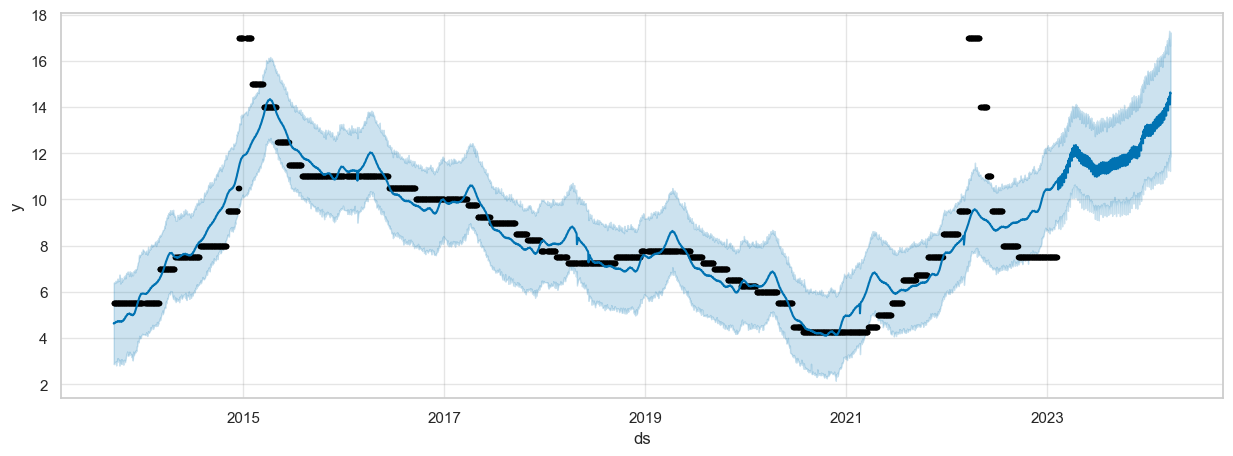

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series cont

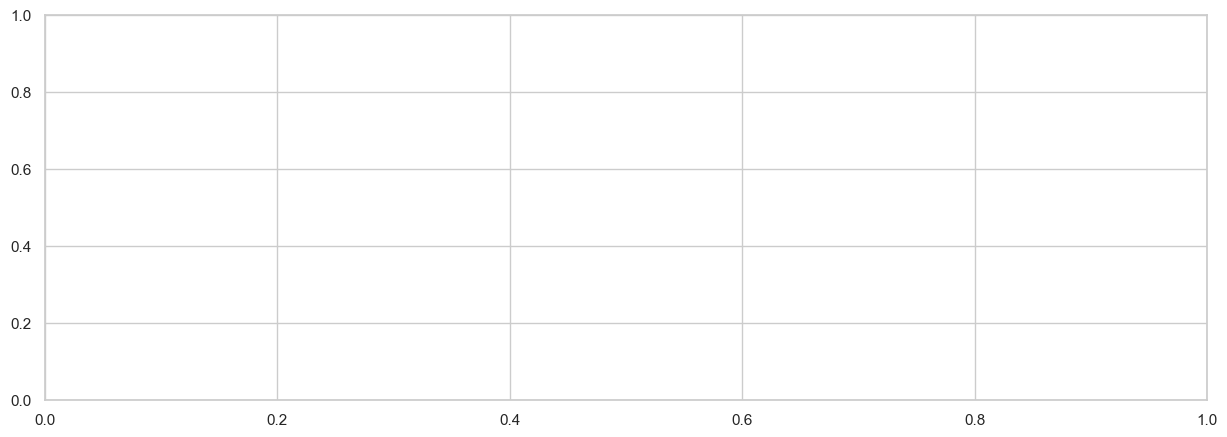

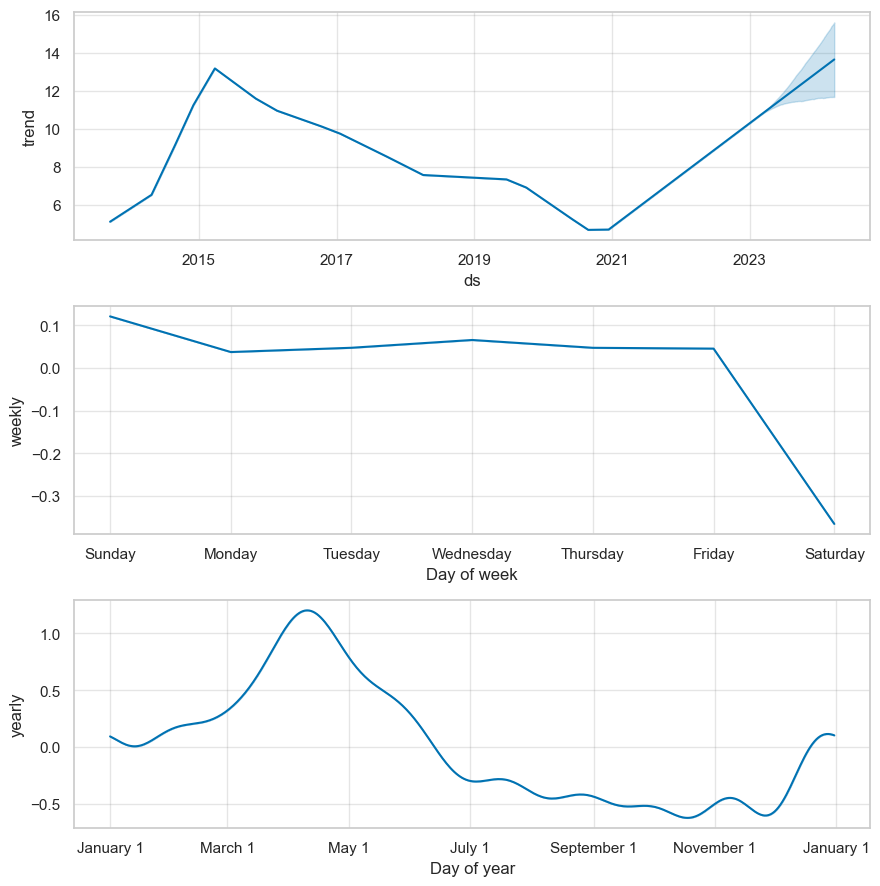

In [27]:
# Смотрим график прогноза, тренд, годовые и сезонные признаки после обучния на лучших параметрах
plot_forecast(final_test_model, forecast)

## Сравнение фактов и прогнозов

In [28]:
# Создание df с прогнозом
df_test_forecast_final = final_test_model.predict(df_test)
df_test_forecast_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
408,2024-09-16,14.469816,10.352610,18.469885
409,2024-09-17,14.486070,10.514113,18.522769
410,2024-09-18,14.511207,10.817774,18.575272
411,2024-09-19,14.500398,10.543261,18.148230
412,2024-09-20,14.506446,10.626829,18.265430


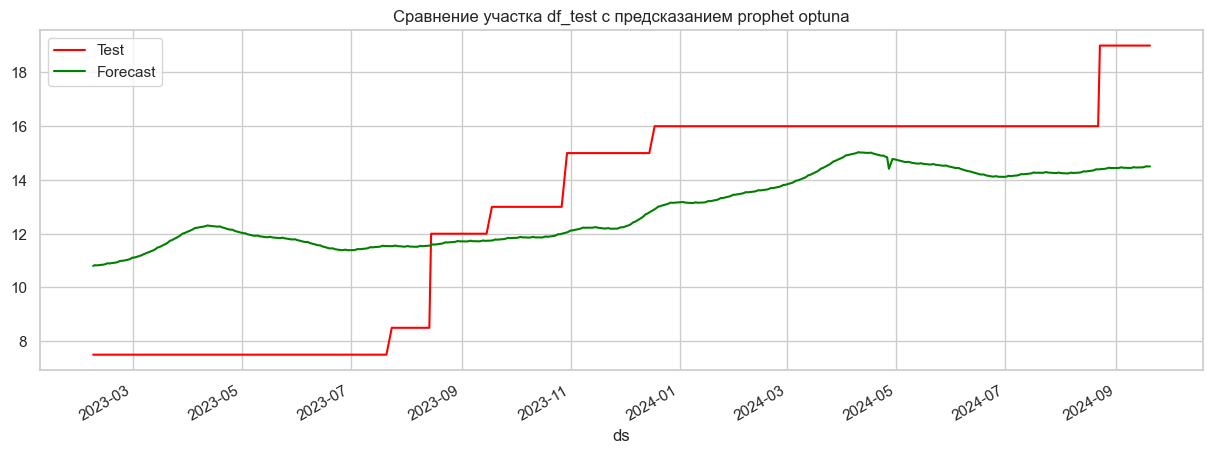

In [29]:
# Сравнение участка df_test с предсказанием prophet optuna
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet optuna')
plt.show()

In [30]:
# Сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_final['yhat'], name='Prophet_best_params_optuna')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,2.719605,0.253811,8.776287,2.962480
0,Prophet_with_holidays,2.694707,0.253057,8.712505,2.951695
0,Prophet_best_params_optuna,2.604822,0.250356,8.501046,2.915655


In [31]:
# # Сохранение метрик
# with open(metrics_path, 'w') as f:
#     json.dump(metrics, f)

In [32]:
# Добавляем столбец в metrics с текущей датой и временем
metrics['date'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

In [33]:
# Сохранение метрик
metrics.to_json(metrics_path, orient='records', lines=True, mode='a')

# Обучение и прогнозирование курса ставки рефинансирования ЦБ РФ на полных данных с пронозированием на будущий период

# Prophet baseline on df

In [34]:
# Обучение модели на df
prophet_bl = train_model(df)

In [35]:
# Создание df с прогнозом
forecast_bl = generate_forecast(prophet_bl, pred_days_forecast)

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


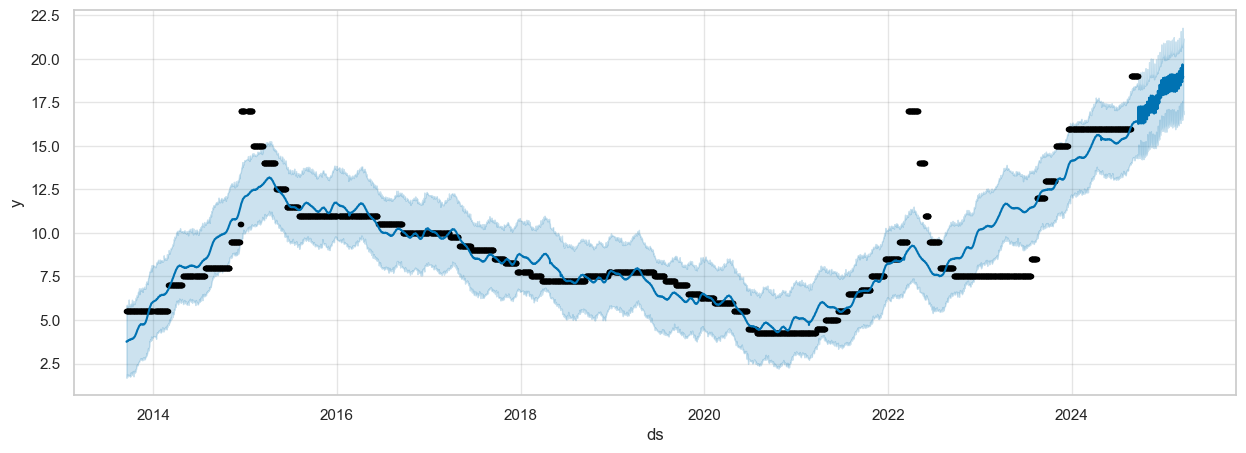

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series cont

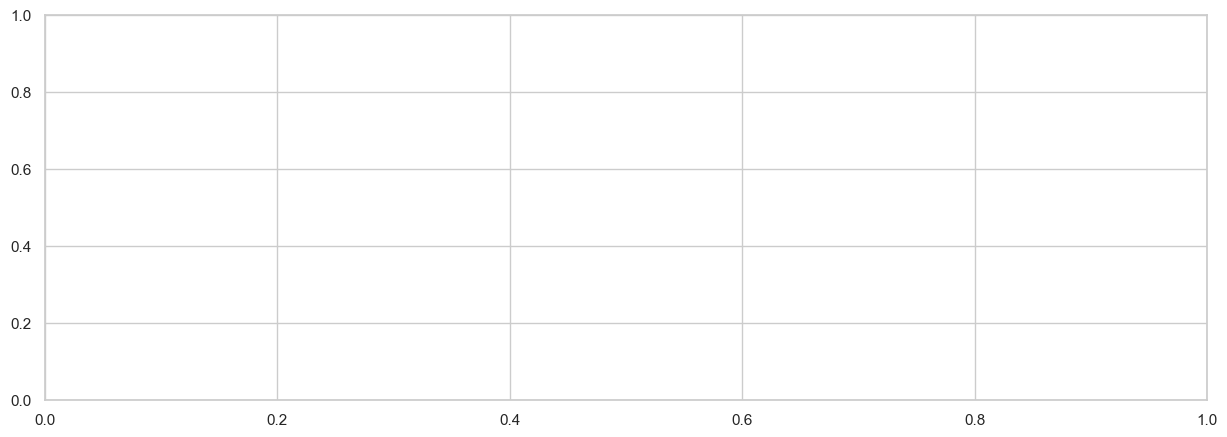

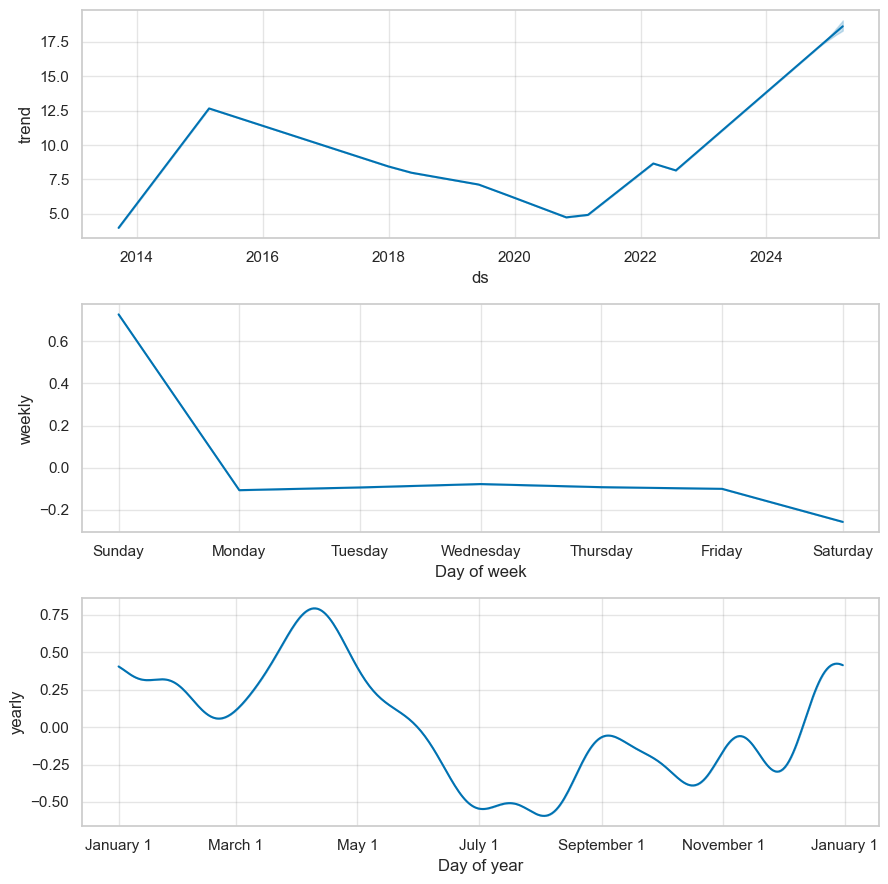

In [36]:
# Смотрим график прогноза, тренд, годовые и сезонные признаки после обучния на лучших параметрах
plot_forecast(prophet_bl, forecast_bl)

# Prophet best params on df

In [37]:
# Обучение модели с лучшими параметрами на df
final_test_model = train_model(df, **prophet_best_params)

In [38]:
# Создание df с прогнозом
forecast_ftm = generate_forecast(final_test_model, pred_days_forecast)

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


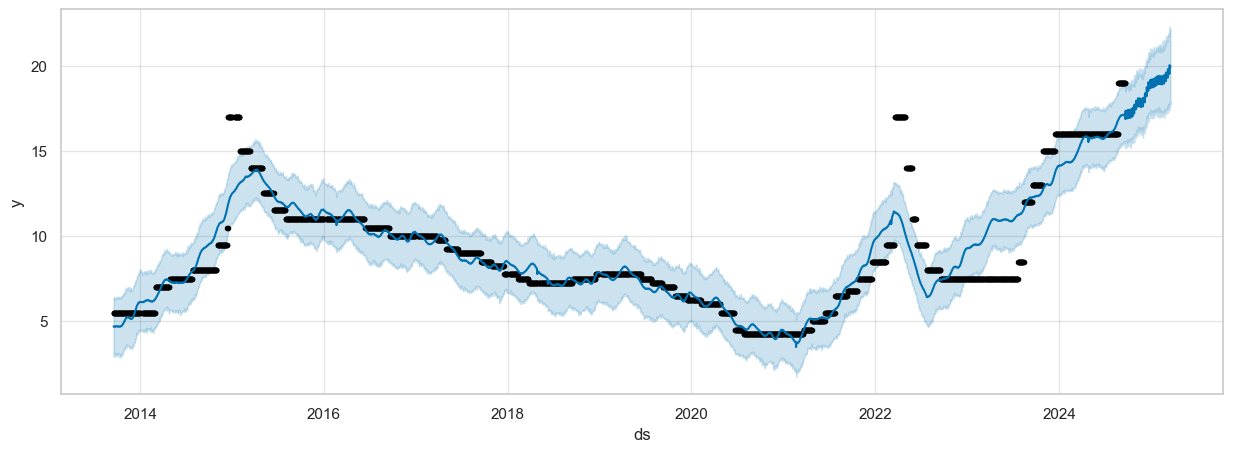

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series cont

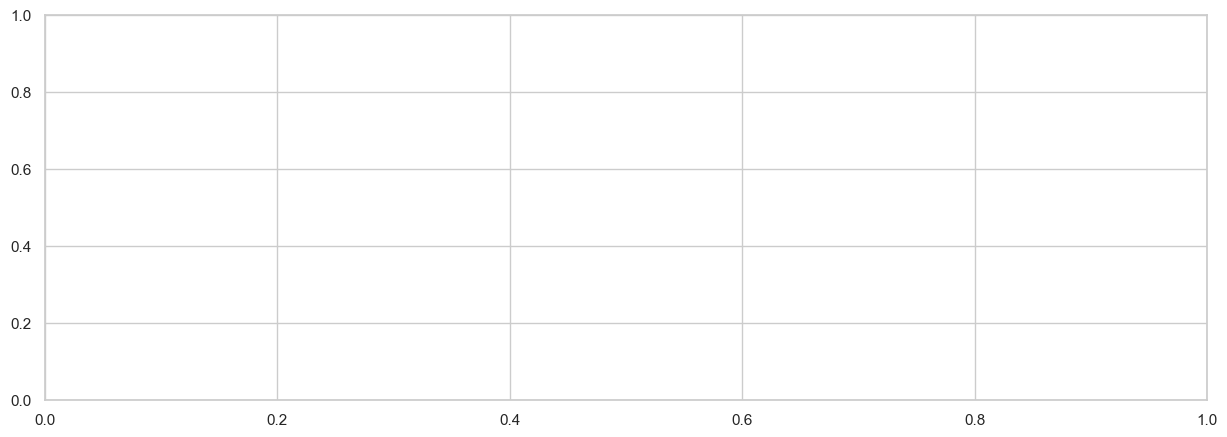

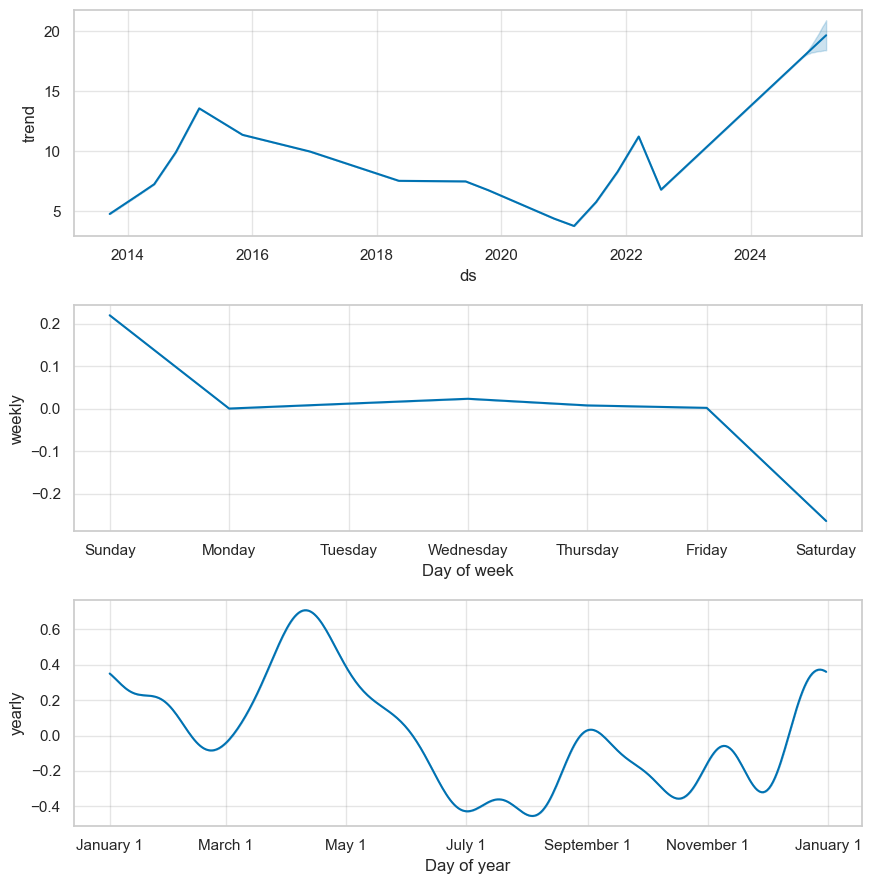

In [39]:
# Смотрим график прогноза, тренд, годовые и сезонные признаки после обучния на лучших параметрах
plot_forecast(final_test_model, forecast_ftm)

# Сравнение прогнозов обученных моделей

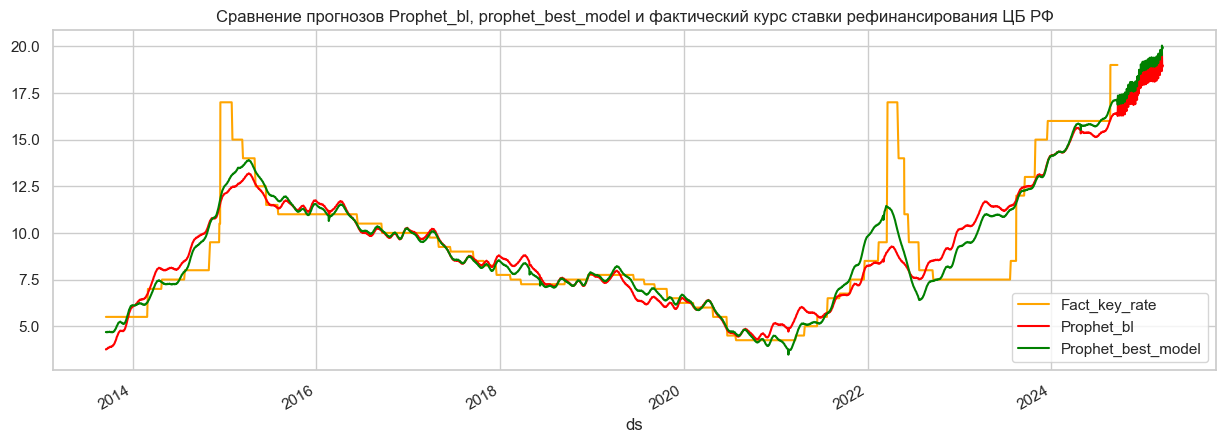

In [40]:
# Сравнение прогнозов Prophet_bl, prophet_best_model и фактический курс ставки рефинансирования ЦБ РФ
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df.plot(kind='line',x='ds', y='y', color='orange', label='Fact_key_rate', ax=ax)
forecast_bl.plot(kind='line', x='ds', y='yhat', color='red', label='Prophet_bl', ax=ax)
forecast_ftm.plot(kind='line', x='ds', y='yhat', color='green', label='Prophet_best_model', ax=ax)
plt.title('Сравнение прогнозов Prophet_bl, prophet_best_model и фактический курс ставки рефинансирования ЦБ РФ')
plt.show()

In [41]:
# Вычисление последней даты в df
last_date = df['ds'].max()

# Создание df с курсами ставки рефинансирования, фактический курс, прогноз бейзлайна, прогноз с лучшими параметрами
key_rate = pd.DataFrame({
    'date': [last_date],
    'fact': [df.loc[df['ds'] == last_date, 'y'].iloc[0]],
    'baseline': [forecast_bl.loc[forecast_bl['ds'] == last_date, 'yhat'].iloc[0]],
    'best_params': [forecast_ftm.loc[forecast_ftm['ds'] == last_date, 'yhat'].iloc[0]]
})

# Отображение df
key_rate

,date,fact,baseline,best_params
0,2024-09-20,19.0,16.419035,17.130411
